In [1]:
#импортирт необходимых бибилиотек
import pandas as pd
import numpy as np
import math as m
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import json

In [2]:
class Calc:
    def __init__(self, h1, gamma_water, angle, d, temp_grad, roughness) -> None:
        """
        Создание объекта расчетника
        """
        self.h1 = h1
        self.gamma_water = gamma_water
        self.angle = angle
        self.d = d
        self.roughness = roughness
        self.temp_grad = temp_grad

    # функция расчета плотности воды в зависимости от давления и температуры
    def rho_w_kgm3(self, t, ws = 0):
        rho_w_sc_kgm3 = 1000*(1.0009 - 0.7114 * ws + 0.2605 * ws**2)**(-1)
        return rho_w_sc_kgm3 /(1+(t-273)/10000*(0.269*(t-273)**(0.637)-0.8))

    # функция расчета солености через плотсноть
    def salinity_gg(self, rho_kgm3):
        sal = 1/rho_kgm3*(1.36545*rho_kgm3-(3838.77*rho_kgm3-2.009*rho_kgm3**2)**0.5)
        # если значение отрицательное, значит скорее всего плотность ниже допустимой 992 кг/м3
        if sal>0 :
            return sal
        else:
            return 0

    # Расчет вязкости воды в зависимости от температуры и давления
    def visc_w_cP(self, p, t, ws = 0):
        a = 109.574 - 0.8406 * 1000 * ws + 3.1331 * 1000 * ws ** 2 + 8.7221 * 1000 * ws ** 3
        b = 1.1217 - 2.6396 * ws + 6.7946 * ws ** 2 + 54.7119 * ws ** 3 - 155.586 * ws ** 4

        return a * (1.8 * t - 460) ** (-b) * (0.9994 + 0.0058 * p + 0.6534 * 1e-4 * p ** 2)

    def Re(self, q, d, mu_mPas = 0.2, rho_kgm3 = 1000):
        v_ms = q / (np.pi * d ** 2 / 4)
        return rho_kgm3 * v_ms * d / mu_mPas

    def friction_Churchill(self, q,d_m = 0.089, mu_mPas = 0.2,rho_kgm3 = 1000,roughness=0.000018):
        Re_val = self.Re(q,d_m,mu_mPas,rho_kgm3)
        A = (-2.457 * np.log((7/Re_val)**(0.9)+0.27*(roughness/d_m)))**16
        B = (37530/Re_val)**16
        return 8 * ((8/Re_val)**12+1/(A+B)**1.5)**(1/12)
    #Расчет функции градиента давления
    def dp_dh(self, h, pt, q_liq):

        rho = self.rho_w_kgm3(pt[1])
        mu = self.visc_w_cP(pt[0]/101325/10, pt[1], self.salinity_gg(rho))/ 1000
        print(q_liq, self.d, mu, rho, self.roughness)
        f = self.friction_Churchill(q_liq, self.d, mu, rho, self.roughness)
        dp_dl_grav = rho * 9.81 * m.sin(self.angle/180* m.pi)
        dp_dl_fric = -f * rho * q_liq** 2 / self.d ** 5
        return dp_dl_grav + 0.815 * dp_dl_fric, self.temp_grad/100

    def calc_pwf_pfl(self, p_wh, t_wh, q):
        result = solve_ivp(
            self.dp_dh,
            t_span=(0, self.h1),
            y0=[p_wh, t_wh],
            args=[q],
        )
        return result.y[0, :][-1]

In [3]:
#входные данные
file = '9.json'

In [4]:
data = pd.read_json('9.json', typ='series').to_dict()
print(data)

{'gamma_water': 1.047289787042837, 'md_vdp': 3158.211680351782, 'd_tub': 0.705515453638336, 'angle': 49.51670335256148, 'roughness': 0.0007305648759510001, 'p_wh': 138.5552635782035, 't_wh': 27.00178710409625, 'temp_grad': 2.628823695420585}


In [5]:
# Входные данные для проведения расчета
gamma_water = data['gamma_water']
p_wh = data['p_wh']         # давление на устье, бар
t_wh = data['t_wh']          # температура на устье скважины, С
temp_grad = data['temp_grad']      # температурный градиент град С на 100 м
md_vdp = data['md_vdp']          # измеренная глубина забоя скважины, м
roughness = data['roughness'] # шероховатость
angle = data['angle'] # угол искривления скважины
d_tub = data['d_tub']/10      # диаметр НКТ по которой ведется закачка, м

In [6]:
pwf_list = []
q_list = [_ for _ in range(1, 400, 10)]
well_calc = Calc(md_vdp, gamma_water, angle, d_tub, temp_grad, roughness)

In [7]:
for q in q_list:
    pwf = well_calc.calc_pwf_pfl(p_wh*101325, t_wh+273, q/86400) # рассчет забойного давления
    pwf_list.append(pwf/101325)

1.1574074074074073e-05 0.0705515453638336 0.0008978946989650947 995.3500159026978 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.0008829785461527627 995.1559359906566 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.0008978392077674776 995.3493117965753 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.0008978114644692717 995.3489597235284 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.0008976727710100904 995.3471991584486 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.0008976481184116576 995.3468861342324 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.0008976173043683944 995.3464948391601 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.0008976173043683944 995.3464948391601 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.000897062975441024 995.3394487158753 0.0007305648759510001
1.1574074074074073e-05 0.0705515453638336 0.00089678604052235 995

0.0009375 0.0705515453638336 0.0003199607827180167 951.2435446349575 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.0008978946989650947 995.3500159026978 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.0008829337910838228 995.155384775157 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.0008978391638260631 995.3493114010816 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.0008978113985603246 995.3489591302654 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.000897672595294671 995.3471975761144 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.0008976479231805535 995.3468843760241 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.0008976170847449999 995.3464928610928 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.0008976170847449999 995.3464928610928 0.0007305648759510001
0.0010532407407407407 0.0705515453638336 0.0008970623171937974 995.3394427771834 0.0007

0.001863425925925926 0.0705515453638336 0.0006619142808147243 990.6594034947873 0.0007305648759510001
0.001863425925925926 0.0705515453638336 0.0005370489308856322 984.7633145946941 0.0007305648759510001
0.001863425925925926 0.0705515453638336 0.0004918353654461939 981.3839094434373 0.0007305648759510001
0.001863425925925926 0.0705515453638336 0.00035275546289845856 960.8709480583843 0.0007305648759510001
0.001863425925925926 0.0705515453638336 0.00033696848721686694 956.680152285484 0.0007305648759510001
0.001863425925925926 0.0705515453638336 0.00031956362339267724 951.2435446349575 0.0007305648759510001
0.001863425925925926 0.0705515453638336 0.0003195852637955129 951.2435446349575 0.0007305648759510001
0.001979166666666667 0.0705515453638336 0.0008978946989650947 995.3500159026978 0.0007305648759510001
0.001979166666666667 0.0705515453638336 0.0008828245981500495 995.1540396145868 0.0007305648759510001
0.001979166666666667 0.0705515453638336 0.00089783905713118 995.3493104397405 0.

0.002673611111111111 0.0705515453638336 0.0008180273361667902 994.1877244832839 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.000794934863976034 993.7876366467458 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.0006943074859036549 991.6046026556678 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.000678590481627912 991.185812138324 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.0006614589171924066 990.649758191644 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.0006614590199005519 990.649758191644 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.0005366241937941206 984.7538348036318 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.0004914089013763231 981.3749214871453 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.0003522621549310815 960.8675627997851 0.0007305648759510001
0.002673611111111111 0.0705515453638336 0.0003364600752121709 956.6782050559212 0.00073

0.0034837962962962965 0.0705515453638336 0.0004908314978642103 981.362640576254 0.0007305648759510001
0.0034837962962962965 0.0705515453638336 0.0003515966196327495 960.8629381494976 0.0007305648759510001
0.0034837962962962965 0.0705515453638336 0.00033577448846325417 956.6755449641885 0.0007305648759510001
0.0034837962962962965 0.0705515453638336 0.0003183256943794148 951.2435446349575 0.0007305648759510001
0.0034837962962962965 0.0705515453638336 0.0003183477307600676 951.2435446349575 0.0007305648759510001
0.003599537037037037 0.0705515453638336 0.0008978946989650947 995.3500159026978 0.0007305648759510001
0.003599537037037037 0.0705515453638336 0.0008824682473770919 995.1496466172929 0.0007305648759510001
0.003599537037037037 0.0705515453638336 0.0008978387138797845 995.349307337084 0.0007305648759510001
0.003599537037037037 0.0705515453638336 0.0008978107236732084 995.3489530340377 0.0007305648759510001
0.003599537037037037 0.0705515453638336 0.0008976707960240702 995.347181316420

0.004293981481481481 0.0705515453638336 0.0008978104078535283 995.3489501679744 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.000897669954040104 995.3471736721282 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.000897644988577713 995.346857815142 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.0008976137834918117 995.3464629788385 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.0008976137834918117 995.3464629788385 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.0008970524228611506 995.3393530622874 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.0008967719771429767 995.3357960701302 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.0008953720916560133 995.3179907812026 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.0008951236309957078 995.3148218511385 0.0007305648759510001
0.004293981481481481 0.0705515453638336 0.0008948132279589094 995.3108591841404 0.000

In [8]:
#Выгрузка полученных результатов
import json
with open('output.json', 'w', encoding='utf-8') as output_file:
        json.dump({"q_liq": q_list, "p_wf": pwf_list}, output_file, indent=4)

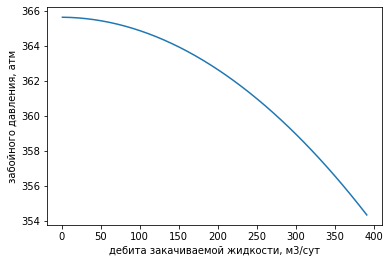

In [9]:
#отрисовка графика зависимости
plt.plot(q_list, pwf_list)
plt.ylabel('забойного давления, атм')
plt.xlabel('дебита закачиваемой жидкости, м3/сут')
plt.show()